In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In the solution 1, i have build a LSTM Sequence2Sequence model to predict nextday electric consumption given previous 7 days of electric consumption data. And it is seen that model was good in training dataset but in testing dataset model did not predict well. Even Mean Loss on testing dataset was '0.013'.  

Now in this solution i will use same LSTM encoder decoder model but will frame the problem in different way. Now the will predict next day electric consumption given previous 24 hours of data.

First i will load the preprocessed data from pickle file 'energy_data_preprocessed.pkl' and then will proceed with further processing, analysis, model building and testing.

In [2]:
energy_data = pd.read_pickle('energy_data_preprocessed.pkl')
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
 7   Sub_metering_4         float32
dtypes: float32(8)
memory usage: 79.2 MB


Lets now resample energy data by hour so that it gives hourly mean electric consumption

In [104]:
hourly_data = energy_data.resample('H').mean()
hourly_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Date_Time,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643890,18.100000,0.0,0.527778,16.861111,52.992592
2006-12-16 18:00:00,3.632200,0.080033,234.580170,15.600000,0.0,6.716667,16.866667,36.953335
2006-12-16 19:00:00,3.400233,0.085233,233.232498,14.503333,0.0,1.433333,16.683332,38.553890
2006-12-16 20:00:00,3.268567,0.075100,234.071503,13.916667,0.0,0.000000,16.783333,37.692780
2006-12-16 21:00:00,3.056467,0.076667,237.158661,13.046667,0.0,0.416667,17.216667,33.307777


Lets check for multicolinearity for hourly data.

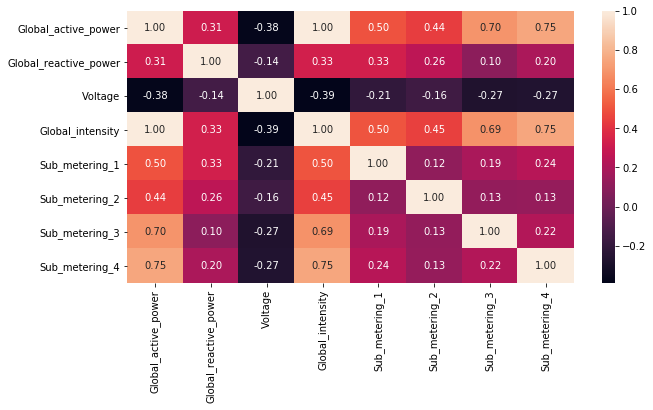

In [4]:
plt.figure(figsize=(10,5))
sns.heatmap(hourly_data.corr(), fmt='.2f', annot=True)
plt.show()

No strong corelation between features. I can even plot relationship using scatter plot as i did in option 1.

Next need to perform MinMaxScaler to bring the features within a smaller range

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(hourly_data)
hourly_data = pd.DataFrame(scaled_values, index=hourly_data.index, columns=hourly_data.columns)

In [105]:
hourly_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1.089449,0.123685,240.836731,4.618529,1.118435,1.291083,6.448848,9.299393
std,0.895008,0.066627,3.001375,3.746606,3.526990,4.175215,7.341338,8.250669
min,0.124000,0.000000,225.834503,0.503333,0.000000,0.000000,0.000000,1.379444
25%,0.342667,0.078033,239.185165,1.516667,0.000000,0.000000,0.650000,4.353333
50%,0.801333,0.107033,240.976166,3.416667,0.000000,0.333333,1.650000,5.747222
75%,1.575333,0.149367,242.687668,6.583333,0.000000,0.650000,14.133333,11.113889
max,6.560534,0.774333,251.901993,28.383333,48.366665,46.433334,21.549999,64.837219


Lets check histogram of feature 'Sub_metering_1'.

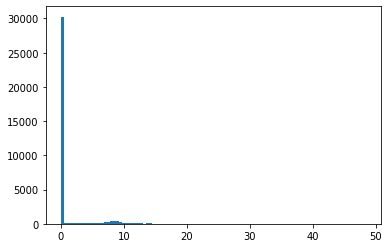

In [106]:
plt.hist(hourly_data.Sub_metering_1, bins=100)
plt.show()

Both from above histogram and statistics i can understand most of the values are 0. In the statistic table above 25th, 50th and 75th Quartile values are 0.0. Hence i will transform this feature such a way that it can have either 0 or 1 value. If value is greater than 0.0 then replace it with 1 else 0.

In [107]:
hourly_data.Sub_metering_1 = hourly_data.Sub_metering_1.apply(lambda x: 0.0 if x== 0.0 else 1.0)

Same approach i will apply for feature 'Sub_metering_2'

In [39]:
hourly_data.Sub_metering_2 = hourly_data.Sub_metering_2.apply(lambda x: 0.0 if x== 0.0 else 1.0)

Now all features are within a range of 0 to 1

#### Train and Test Splitting
Next step is to split the dataset into training and testing set. Remember the dataset contains every hours mean electric consumptions thorughout years. Random splitting with a ration (80:20) wont be desirable because our final goal is to use LSTM model where order of data instances is important. Hence i will use 2010 electric consumption data for Testing the model and rest for training the model.

In [43]:
print('Hourly Data Starts from ', hourly_data.index[0])

Hourly Data Starts from  2006-12-16 17:00:00


So electric consumption data starts from 16th Dec, 2006 - 5PM onwards. I will exclude this 16th Dec data as it do not have 24 hours data available. So training dataset should start from 17th Dec,2006 12 o'clock onwards till 31st Dec, 2009 11 PM.

In [44]:
print('Hourly Data Ends on ', hourly_data.index[-1])

Hourly Data Ends on  2010-11-26 21:00:00


So electric consumption data ends on 26th Nov, 2010, 9PM. I will exclude 26th Nov data aswell because the day do not havle 24 hours data. Hence testing data should contain records starting from 1st jan, 2010 to 25th Nov, 2010.

In [45]:
from datetime import date
no_of_days = abs(date(2006,12,17) - date(2010, 1, 1)).days
print('No of days to consider for Training Data Set ', no_of_days )
no_of_hours = no_of_days * 24
print('No of Hours to consider for training data set ', no_of_hours)

No of days to consider for Training Data Set  1111
No of Hours to consider for training data set  26664


Training dataset will have 1111 days of hourly data and hence 26664 hours of data within a period of 4 years (2006 to 2009). Lets split the hourly data into training data.

In [46]:
training_data = hourly_data.iloc[7:no_of_hours+7]
testing_data = hourly_data.iloc[26671: -22]

Lets just cross verify training and testing dataset.

In [47]:
print('Training Dataset : between {} and {}'.format(training_data.index[0], training_data.index[-1]))
print('Testing Dataset : between {} and {}'.format(testing_data.index[0], testing_data.index[-1]))

Training Dataset : between 2006-12-17 00:00:00 and 2009-12-31 23:00:00
Testing Dataset : between 2010-01-01 00:00:00 and 2010-11-25 23:00:00


So training and testing split is as i expected. Now i need to reshape these datasets into a 3D format because final LSTM model accepts sequences. Likewise Option1 i will convert these training and testing datasets into a list of sequences where each sequence contains 24 hours of electric consumption data for 8 variables.

In [48]:
training_data = np.array(np.split(training_data.values, 1111))
testing_data = np.array(np.split(testing_data.values, 329))
print('New Shape of Training Data ', training_data.shape)
print('New Shape of Testing Data ', testing_data.shape)

New Shape of Training Data  (1111, 24, 8)
New Shape of Testing Data  (329, 24, 8)


The 3D input sequences are ready, one last task is pending before sending these data to LSTm model, which is i need to prepare input and output sequences as like i did in Option1.

Input sequence will have 24 hours of data and output sequence will have next 24 hours of data.

In [85]:
data = training_data.reshape(training_data.shape[0]*training_data.shape[1] , training_data.shape[2])

lag_size = 24
start_hour_indx = 0
inp_data = []
op_data = []

for i in range(len(data)):
    end_hour_indx = start_hour_indx + lag_size
    inp_ = data[start_hour_indx : end_hour_indx, :]
    start_hour_indx += 1
    
    op_end = end_hour_indx+lag_size
    op_ = data[end_hour_indx: op_end, 0]
    
    if op_end <= len(data):
        inp_data.append(inp_)
        op_data.append(op_)

inp_data = np.array(inp_data)
op_data = np.array(op_data)
op_data = op_data.reshape(op_data.shape[0], op_data.shape[1], 1)
print('Input Shape for LSTM ', inp_data.shape)
print('Output Shape for LSTM ', op_data.shape)

Input Shape for LSTM  (26617, 24, 8)
Output Shape for LSTM  (26617, 24, 1)


Finally Training input and output sequences are ready. I am good to go for LSTM encoder decoder model. Also notice the length of training data is increased to 26617.

I am going to train my model with 50 epochs and with a batch size of 16. LSTM layer's hidden neuron size is set to 64 neurons.

In [96]:
verbose = 1
epochs = 50
batch_size = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, dropout=0.2, activation='relu'))
model.add(tf.keras.layers.RepeatVector(lag_size))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.2, activation='relu'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

model.compile(loss='mse', optimizer='adam')

history = model.fit(inp_data, op_data, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split= 0.2)

Train on 21293 samples, validate on 5324 samples
Epoch 1/50
21293/21293 [==============================] - 48s 2ms/sample - loss: 0.0206 - val_loss: 0.0144
Epoch 2/50
21293/21293 [==============================] - 50s 2ms/sample - loss: 0.0198 - val_loss: 0.0136
Epoch 3/50
21293/21293 [==============================] - 43s 2ms/sample - loss: 0.0188 - val_loss: 0.0131
Epoch 4/50
21293/21293 [==============================] - 40s 2ms/sample - loss: 0.0166 - val_loss: 0.0104
Epoch 5/50
21293/21293 [==============================] - 39s 2ms/sample - loss: 0.0154 - val_loss: 0.0097
Epoch 6/50
21293/21293 [==============================] - 39s 2ms/sample - loss: 0.0149 - val_loss: 0.0107
Epoch 7/50
21293/21293 [==============================] - 40s 2ms/sample - loss: 0.0147 - val_loss: 0.0096
Epoch 8/50
21293/21293 [==============================] - 44s 2ms/sample - loss: 0.0145 - val_loss: 0.0094
Epoch 9/50
21293/21293 [==============================] - 40s 2ms/sample - loss: 0.0143 - val_l

Lets plot the training loss and validation loss. I had used vaidation_split=0.2 which means 20% of my training data is used for validating the mdoel.

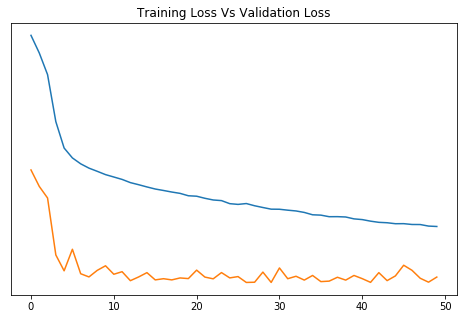

In [98]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss Vs Validation Loss')
plt.yticks([])
plt.show()

From above plot i can see that training loss and validation loss has been reduced over number of epochs.However validation loss is fluctuating. This can be resolved by increasing number of epochs, batch size and or more feature engineering.  

Lets plot prediction of training data and see how well model has predicted over training data.

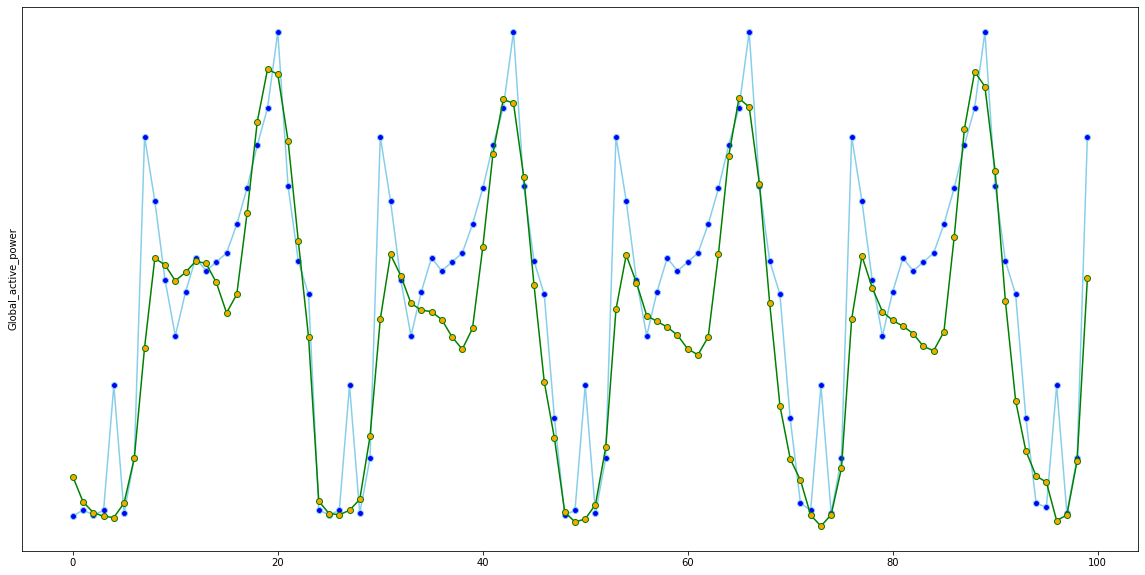

In [100]:
y_pred = model.predict(inp_data)
y_actual = op_data.flatten()
y_predicted = y_pred.flatten()

plt.figure(figsize=(20,10))
plt.plot(y_actual[:100], marker='o', markerfacecolor='blue', color='skyblue')
plt.plot(y_predicted[:100], marker='o', markerfacecolor='orange', color='green')
plt.ylabel('Global_active_power')
plt.yticks([])
plt.show()

Not bad. Quiet well prediction over training data. Lets visualise for testing data.

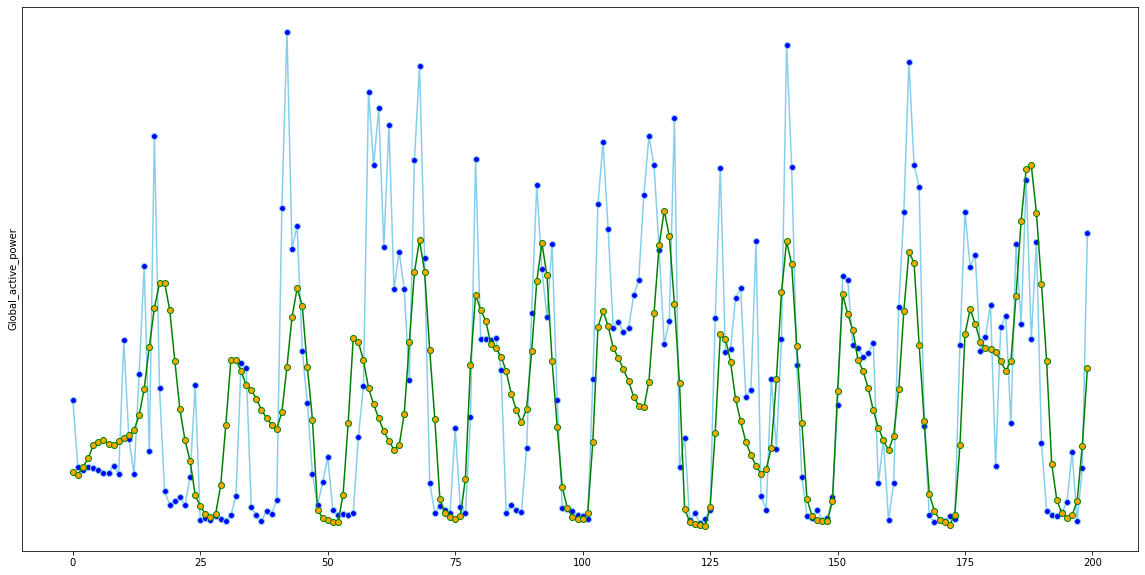

In [101]:
test_x = testing_data[:,:, :]
test_y = testing_data[:, : , 0]
y_pred = model.predict(test_x)
y_actual = test_y.flatten()
y_predicted = y_pred.flatten()

plt.figure(figsize=(20,10))
plt.plot(y_actual[:200], marker='o', markerfacecolor='blue', color='skyblue')
plt.plot(y_predicted[:200], marker='o', markerfacecolor='orange', color='green')
plt.ylabel('Global_active_power')
plt.yticks([])
plt.show()

Not so accurate like training data but quiet well as compare to Solution 1.  

Here is the Actual and predicted electric consumption

In [102]:
pd.DataFrame({
    'Actual_Consumption' : y_actual,
    'Predicted_Consumption' : y_predicted
})

,Actual_Consumption,Predicted_Consumption
0,0.149439,0.077239
1,0.081913,0.074309
2,0.079328,0.082229
3,0.082187,0.090487
4,0.081110,0.103671
...,...,...
7891,0.342804,0.302720
7892,0.236748,0.315572
7893,0.189377,0.263364
7894,0.174561,0.176210


Lets calculate Mean Squared Error (MSE) of the mdoel. MSE is the squared difference between actual values and target values. The MSE will help to compare between models.

In [103]:
testing_mse = (sum((y_actual - y_predicted)**2))/len(y_actual)
print('Means Squared Erro of the model is ', testing_mse)

Means Squared Erro of the model is  0.009524541109867007


Great job ! MSE has been reduced in this solution.